In [4]:
import pandas as pd

df = pd.read_csv("../data/uk_ecommerce_cleaned.csv")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26:00,3.39,17850,United Kingdom


In [5]:
df.shape


(407212, 8)

In [28]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407212 entries, 0 to 407211
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     407212 non-null  object        
 1   StockCode     407212 non-null  object        
 2   Description   407212 non-null  object        
 3   Quantity      407212 non-null  int64         
 4   InvoiceDate   407212 non-null  datetime64[ns]
 5   UnitPrice     407212 non-null  float64       
 6   CustomerID    407212 non-null  object        
 7   Country       407212 non-null  object        
 8   LineRevenue   407212 non-null  float64       
 9   InvoiceYear   407212 non-null  int64         
 10  InvoiceMonth  407212 non-null  int64         
 11  InvoiceHour   407212 non-null  int64         
 12  InvoiceDay    407212 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 40.4+ MB


In [7]:
df.isna().sum()


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407212 entries, 0 to 407211
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    407212 non-null  object        
 1   StockCode    407212 non-null  object        
 2   Description  407212 non-null  object        
 3   Quantity     407212 non-null  int64         
 4   InvoiceDate  407212 non-null  datetime64[ns]
 5   UnitPrice    407212 non-null  float64       
 6   CustomerID   407212 non-null  object        
 7   Country      407212 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 24.9+ MB


In [10]:
df['LineRevenue'] = df['Quantity'] * df['UnitPrice']


In [11]:
df[['Quantity', 'UnitPrice', 'LineRevenue']].head()


,Quantity,UnitPrice,LineRevenue
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


In [30]:
total_revenue = df[df['LineRevenue'] > 0]['LineRevenue'].sum()
total_orders = df['InvoiceNo'].nunique()
total_customers = df[df['CustomerID'] != 'Unknown']['CustomerID'].nunique()
countries = df['Country'].nunique()

total_revenue, total_orders, total_customers, countries


(8911407.900000002, 22372, 4372, 38)

In [32]:
## 2 Time-Based Sales Analysis (VERY IMPORTANT)
monthly_sales = (
    df[df['LineRevenue'] > 0]
    .groupby(['InvoiceYear','InvoiceMonth'])['LineRevenue']
    .sum()
    .reset_index()
)


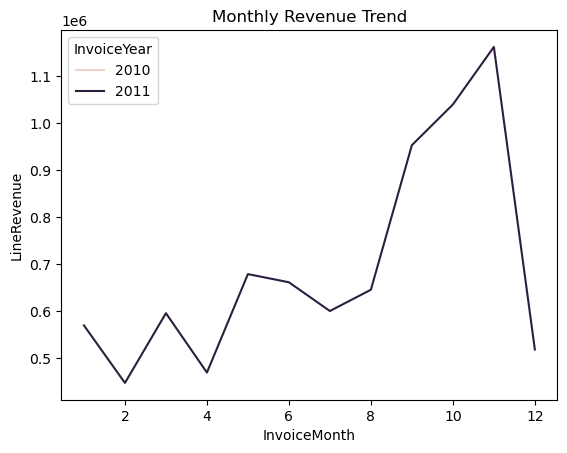

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=monthly_sales, x='InvoiceMonth', y='LineRevenue', hue='InvoiceYear')
plt.title("Monthly Revenue Trend")
plt.show()


In [35]:
orders_by_hour = (
    df.groupby('InvoiceHour')['InvoiceNo']
    .nunique()
    .reset_index(name='order_count')
)

orders_by_hour.head()



,InvoiceHour,order_count
0,6,22
1,7,31
2,8,609
3,9,1628
4,10,2623


In [36]:
## 2.2 Orders by Hour (Peak Business Hours)
orders_by_hour = (
    df.groupby('InvoiceHour')['InvoiceNo']
    .nunique()
    .reset_index(name='order_count')
)


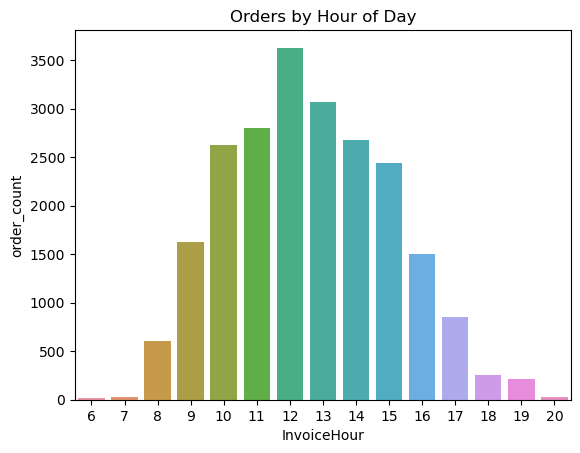

In [37]:
sns.barplot(data=orders_by_hour, x='InvoiceHour', y='order_count')
plt.title("Orders by Hour of Day")
plt.show()


In [38]:
## Customer Behavior Analysis (HIGH VALUE)
#### Repeat vs One-Time Customers (Visual)
customer_orders = (
    df[df['CustomerID'] != 'Unknown']
    .groupby('CustomerID')['InvoiceNo']
    .nunique()
)

customer_type = customer_orders.apply(
    lambda x: 'One-time' if x == 1 else 'Repeat'
)

customer_type.value_counts()


Repeat      3059
One-time    1313
Name: InvoiceNo, dtype: int64

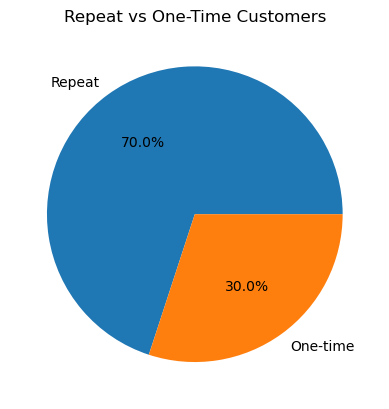

In [39]:
customer_type.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Repeat vs One-Time Customers")
plt.ylabel('')
plt.show()


In [40]:
### 3.2 Revenue Concentration (Top Customers)
customer_revenue = (
    df[df['LineRevenue'] > 0]
    .groupby('CustomerID')['LineRevenue']
    .sum()
    .sort_values(ascending=False)
)

top_10_percent = int(0.1 * len(customer_revenue))
customer_revenue.head(top_10_percent).sum() / customer_revenue.sum()


0.6133411713765228

In [42]:
## 4: Product Performance & Returns Analysis
#### 4.1 Top Products by Revenue
top_products = (
    df[df['LineRevenue'] > 0]
    .groupby('Description')['LineRevenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)


In [43]:
returns = (
    df[df['Quantity'] < 0]
    .groupby('Description')['Quantity']
    .sum()
    .abs()
    .sort_values(ascending=False)
    .head(10)
)

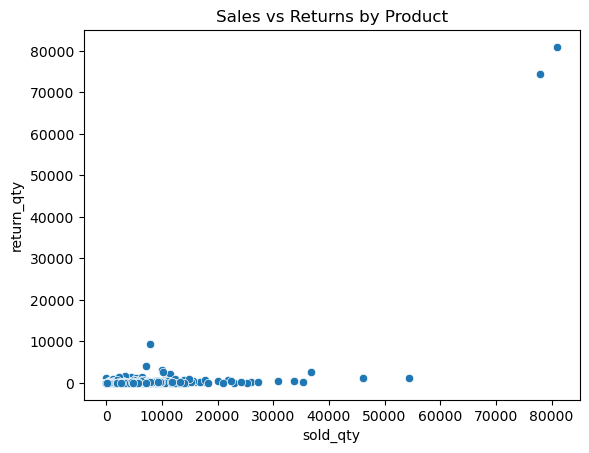

In [44]:
product_summary = (
    df.groupby('Description')
    .agg(
        sold_qty=('Quantity', lambda x: x[x>0].sum()),
        return_qty=('Quantity', lambda x: abs(x[x<0].sum()))
    )
)

sns.scatterplot(data=product_summary, x='sold_qty', y='return_qty')
plt.title("Sales vs Returns by Product")
plt.show()


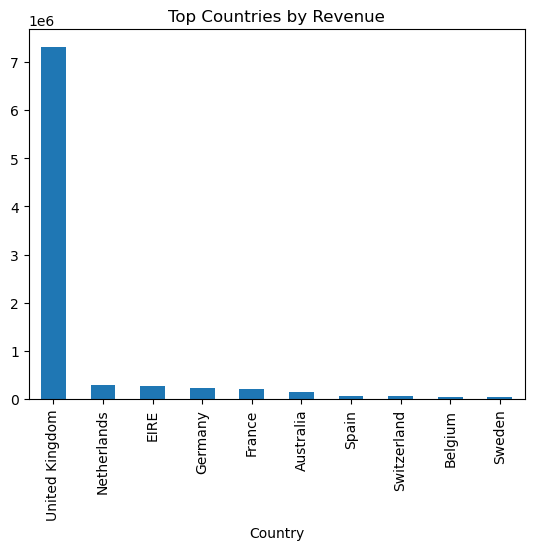

In [45]:
## 5: Country-Wise Analysis

country_sales = (
    df[df['LineRevenue'] > 0]
    .groupby('Country')['LineRevenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

country_sales.plot(kind='bar')
plt.title("Top Countries by Revenue")
plt.show()


In [47]:
import os
os.getcwd()


'/Users/soumenmandal/Notebooks'

In [48]:
import os

os.makedirs("../outputs", exist_ok=True)


In [49]:
monthly_sales.to_csv("../outputs/monthly_sales.csv", index=False)
orders_by_hour.to_csv("../outputs/orders_by_hour.csv", index=False)
country_sales.to_csv("../outputs/country_sales.csv", index=False)


In [51]:
os.listdir("../outputs")


['monthly_sales.csv', 'orders_by_hour.csv', 'country_sales.csv']

In [52]:
monthly_sales.to_csv("../outputs/monthly_sales.csv", index=False)
orders_by_hour.to_csv("../outputs/orders_by_hour.csv", index=False)
country_sales.to_csv("../outputs/country_sales.csv", index=False)
